In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [2]:
# Suppose we are trying to figure out how much something weighs,
# but the scale we’re using is unreliable and gives slightly different
# answers every time we weigh the same object. 
# We could try to compensate for this variability by integrating the
# noisy measurement information with a guess based on some prior knowledge
# about the object, like its density or material properties. 
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [3]:
# We can condition the output based on our measurements
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)

In [4]:
# Solution to our problem which we should not see: 
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [5]:
# Define learnable parameters for our measurement 
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

a =  9.107474327087402
b =  0.6285384893417358


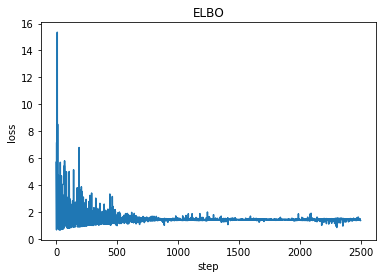

In [6]:
# Stochastic variational inference in Pyro
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())